### Spatial Model
1. VIF and Tukey Test to manage explanatory features
2. Moran's I to test for Spatial Autocorrelation
3. Spatial Regression Models (OLS, SLM, SEM)
4. Hot/Cold Analysis
5. GWR

In [1]:
# Import modules

import pandas as pd
import json, requests
import datetime
from datetime import datetime
#import io
#import os
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from math import sqrt

import pysal as ps
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
from pysal.model import spreg
from splot.esda import plot_moran
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

import numpy as np
import random
random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

In [2]:
## Read in data

# Shape Files
spatial_recovery_mar = gpd.read_file('output_data/spatial_recovery_mar.shp')
spatial_recovery_jun = gpd.read_file('output_data/spatial_recovery_jun.shp')

# Shape Files
boroughs = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')

spatial_recovery_mar = spatial_recovery_mar.to_crs('epsg:27700')
spatial_recovery_jun = spatial_recovery_jun.to_crs('epsg:27700')
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')

In [3]:
spatial_recovery_jun.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 66 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   msoa_name   981 non-null    object  
 1   msoa_code   981 non-null    object  
 2   la_name     981 non-null    object  
 3   la_code     981 non-null    object  
 4   region      981 non-null    object  
 5   subregion   981 non-null    object  
 6   slope       981 non-null    float64 
 7   log_slope   981 non-null    float64 
 8   imd_score   981 non-null    float64 
 9   total_inco  981 non-null    int64   
 10  hw_pct      981 non-null    float64 
 11  cyclelengt  981 non-null    float64 
 12  cars_per_h  981 non-null    float64 
 13  roadlength  981 non-null    float64 
 14  trips_perh  981 non-null    float64 
 15  education_  981 non-null    float64 
 16  busstops_c  981 non-null    float64 
 17  pubtrans_c  981 non-null    float64 
 18  recreation  981 non-null    float64 
 19  

In [4]:
df = spatial_recovery_jun

df.rename({'imd_score_': 'imd_score_std',
                         'total_in_1': 'total_income_std',
                         'cyclelen_1': 'cyclelength_std',
                         'log_cycl_1': 'log_cyclelength_std',
                         'cars_per_1': 'carsperhhld_std',
                         'roadleng_1': 'roadlengths_std',
                         'trips_pe_1': 'trips_std',
                         'log_trip_1': 'log_trips',
                         'educatio_2': 'education_cnt_std',
                         'log_educ_2': 'log_education_cnt',
                         'educatio_3': 'education_den_std',
                         'log_educ_3': 'log_education_den',
                         'busstops_1': 'busstops_cnt_std',
                         'log_buss_2': 'log_busstops_cnt',
                         'busstops_2': 'busstops_den_std',
                         'log_buss_3': 'log_busstops_den',
                         'pubtrans_1': 'pubtrans_cnt_std',
                         'log_pubt_2': 'log_pubtrans_cnt',
                         'pubtrans_2': 'pubtrans_den_std',
                         'log_pubt_3': 'log_pubtrans_den',
                         'recreati_2': 'recreation_cnt_std',
                         'log_recr_2': 'log_recreation_cnt',
                         'recreati_3' : 'recreation_den_std',
                         'log_recr_3': 'log_recreation_den',
                         'coviddea_2': 'coviddeaths_std',
                         'coviddea_3': 'coviddeaths_den_std'},
                        axis = 1,
                        inplace = True)

df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   msoa_name            981 non-null    object  
 1   msoa_code            981 non-null    object  
 2   la_name              981 non-null    object  
 3   la_code              981 non-null    object  
 4   region               981 non-null    object  
 5   subregion            981 non-null    object  
 6   slope                981 non-null    float64 
 7   log_slope            981 non-null    float64 
 8   imd_score            981 non-null    float64 
 9   total_inco           981 non-null    int64   
 10  hw_pct               981 non-null    float64 
 11  cyclelengt           981 non-null    float64 
 12  cars_per_h           981 non-null    float64 
 13  roadlength           981 non-null    float64 
 14  trips_perh           981 non-null    float64 
 15  education_     

### Procedure

1. Feature Selection
2. Spatial Autocorrelation
3. Hotspot Analysis, which will inform how we discuss the strongest model. (i.e, hh/ll for stat significant vars)
4. Spatial Regression Models

Text(0.5, 1.0, 'Spatial Plot of Recovery Rate')

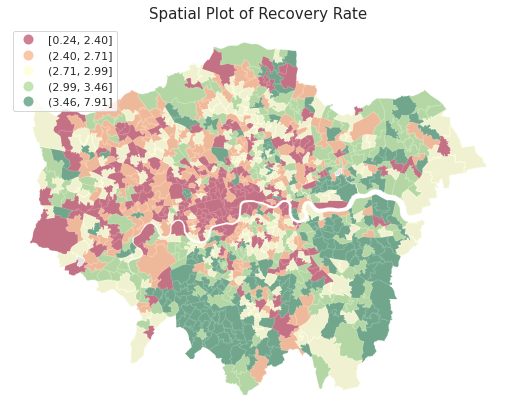

In [5]:
# Plot a chloropeth of slope, code inspired by https://geographicdata.science/book/notebooks/
f, ax = plt.subplots(1, figsize=(9, 9))

#df = spatial_recovery_mar

plotmsoa = msoas.plot(ax=ax,alpha=0.8,color='gainsboro')
plotdf = df.plot(column='slope', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.5, 
                       legend=True,
                       legend_kwds={'fmt':'{:.2f}',"loc": 2},
                       ax=ax
                      )

ax.set_axis_off()
plotdf.set_title("Spatial Plot of Recovery Rate", fontsize = 15)

### Feature Selection
We've created a few versions of the POI variables with various transformations. Here, we explore the correlation with the dependent variable, recovery rate ("slope"). We decided to select the density metrics where POI are a proportion of population density. Then, a VIF is conducted and validated with a correlation matrix.

In [6]:
# Here, we are looking at the correlation with each variable versus slope. Particularly, we're looking to understand where
# the relationship "flips" from negative to positive. Based on what we're seeing, we'll go with the "density" version
# of POIs versus just a count per MSOA. This hopefully accounts for the density of POIs that may impact public transport demand.

df_corr = df[['slope',
              'imd_score_std',
              'total_income_std',
              'hw_pct_std',
              'cyclelength_std',
              'log_cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              'trips_std',
              'log_trips',
              'education_cnt_std',
              'log_education_cnt',
              'education_den_std',
              'log_education_den', #strongest of the four
              'busstops_cnt_std',
              'log_busstops_cnt',
              'busstops_den_std',
              'log_busstops_den', #strongest of the four
              'pubtrans_cnt_std',
              'log_pubtrans_cnt', #strongest of the four
              'pubtrans_den_std',
              'log_pubtrans_den',
              'recreation_cnt_std',
              'log_recreation_cnt',
              'recreation_den_std',
              'log_recreation_den', #strongest of the four
              'coviddeaths_std',
              'coviddeaths_den_std']]

corrMatrix = df_corr.corr(method='pearson')
corrMatrix['slope']

slope                  1.00
imd_score_std         -0.03
total_income_std      -0.11
hw_pct_std            -0.15
cyclelength_std       -0.08
log_cyclelength_std   -0.07
carsperhhld_std        0.21
roadlengths_std       -0.11
trips_std             -0.23
log_trips             -0.29
education_cnt_std     -0.03
log_education_cnt      0.01
education_den_std      0.03
log_education_den      0.07
busstops_cnt_std      -0.02
log_busstops_cnt       0.02
busstops_den_std      -0.01
log_busstops_den       0.11
pubtrans_cnt_std      -0.20
log_pubtrans_cnt      -0.27
pubtrans_den_std      -0.09
log_pubtrans_den       0.15
recreation_cnt_std    -0.01
log_recreation_cnt    -0.01
recreation_den_std     0.01
log_recreation_den     0.05
coviddeaths_std        0.04
coviddeaths_den_std    0.05
Name: slope, dtype: float64

In [7]:
# VIF
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [8]:
test = df
test = test[['slope',
              'imd_score_std',
              'total_income_std',
              'hw_pct_std',
              'cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              #'trips_std',
              'education_den_std',
              'busstops_den_std',
              'pubtrans_den_std',
              'recreation_den_std',
              'coviddeaths_std',
              'coviddeaths_den_std']]

drop_column_using_vif_(test)

Dropping: imd_score_std
Dropping: busstops_den_std


,slope,total_income_std,hw_pct_std,cyclelength_std,carsperhhld_std,roadlengths_std,education_den_std,pubtrans_den_std,recreation_den_std,coviddeaths_std,coviddeaths_den_std
0,4.75,-0.99,-0.11,0.85,-1.00,0.28,0.30,-0.15,-0.26,0.89,-0.05
1,2.76,-1.54,-1.28,1.15,-1.60,0.06,-0.36,0.20,-0.37,-0.55,-0.38
2,3.37,-1.25,0.29,-0.32,-1.00,-0.56,0.03,-0.19,-0.38,-0.55,-0.38
3,4.55,-1.61,-0.54,2.44,-1.30,-0.03,-0.54,-0.19,0.13,0.89,-0.05
4,2.84,0.06,0.67,0.52,-1.00,-0.55,-0.16,-0.16,-0.38,-0.55,-0.38
...,...,...,...,...,...,...,...,...,...,...,...
976,3.32,1.15,1.21,2.68,1.08,-0.33,-0.42,-0.19,-0.20,0.89,0.65
977,3.23,-0.15,0.18,-0.42,1.08,-0.05,0.58,-0.19,0.82,-0.55,-0.38
978,2.86,1.11,1.36,0.43,0.48,-1.67,0.25,0.11,0.24,0.89,2.14
979,3.17,1.22,1.30,1.48,0.78,-0.80,0.48,-0.04,1.01,-0.55,-0.38


Text(0.5, 1.0, 'Correlation Heatmap of Explanatory Factors')

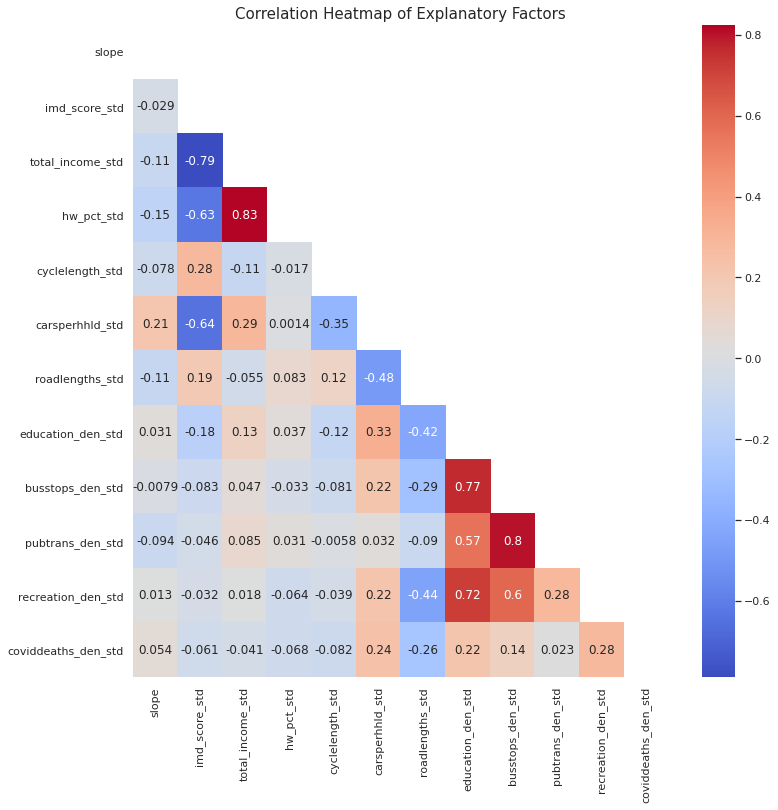

In [9]:
# Correlation Matrix to see which variables have the strongest association with slope
# Code from https://cmdlinetips.com/2020/02/lower-triangle-correlation-heatmap-python/
sns.set_context('notebook')

f, ax = plt.subplots(1, figsize=(12, 12))

df_corr = df[['slope',
              'imd_score_std',
              'total_income_std',
              'hw_pct_std',
              'cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              #'trips_std',
              'education_den_std',
              'busstops_den_std',
              'pubtrans_den_std',
              'recreation_den_std',
              'coviddeaths_den_std']]

corrMatrix = df_corr.corr(method='pearson')
mask_lt = np.triu(np.ones(corrMatrix.shape)).astype(np.bool)
mask_lt[0:13,0:13]
p = sns.heatmap(corrMatrix, mask = mask_lt, cmap='coolwarm', annot= True)

p.set_title("Correlation Heatmap of Explanatory Factors", fontsize = 15)

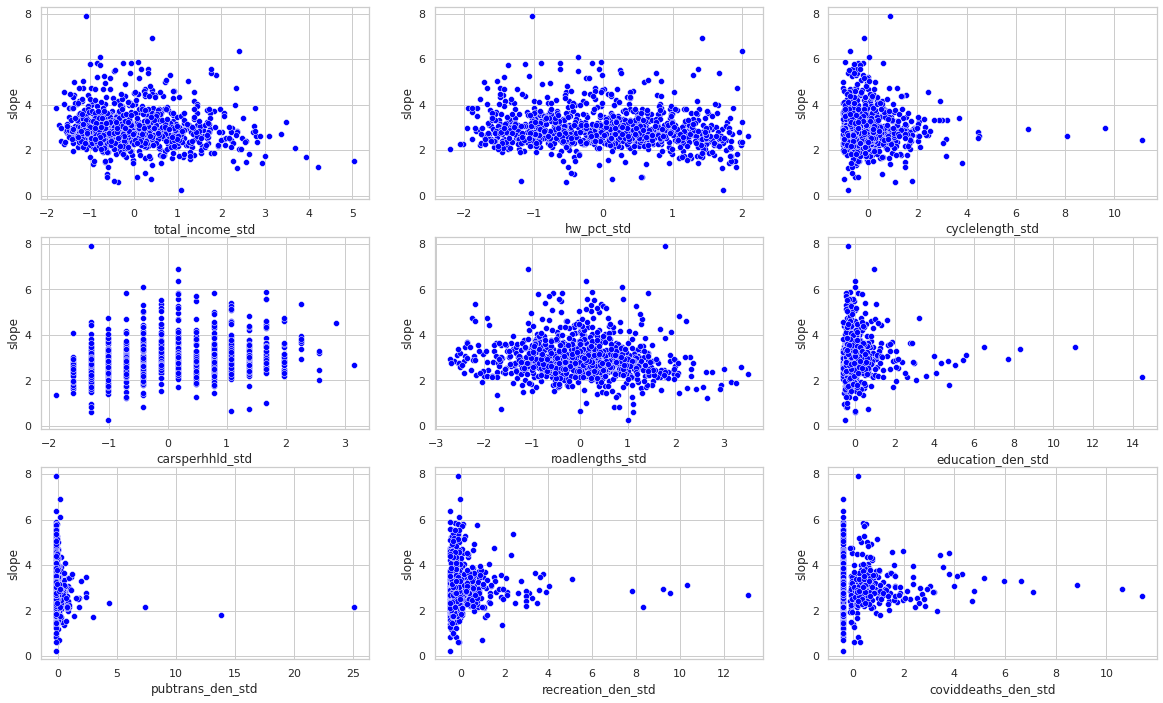

In [10]:
sns.set_context('notebook')

f, ax = plt.subplots(3,3, figsize=(20, 12), sharex = False, sharey = False)

plt_cols = ['total_income_std',
            'hw_pct_std',
              'cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              'education_den_std',
              'pubtrans_den_std',
              'recreation_den_std',
              'coviddeaths_den_std']

k = 0

for i in range(0, 3):
    for j in range(0, 3):
        if k <= (len(plt_cols)-1):
            #print(plt_cols[k])
            sns.scatterplot(x=plt_cols[k], y='slope', data = df, ax=ax[i,j], color = 'blue')
            k = k+1

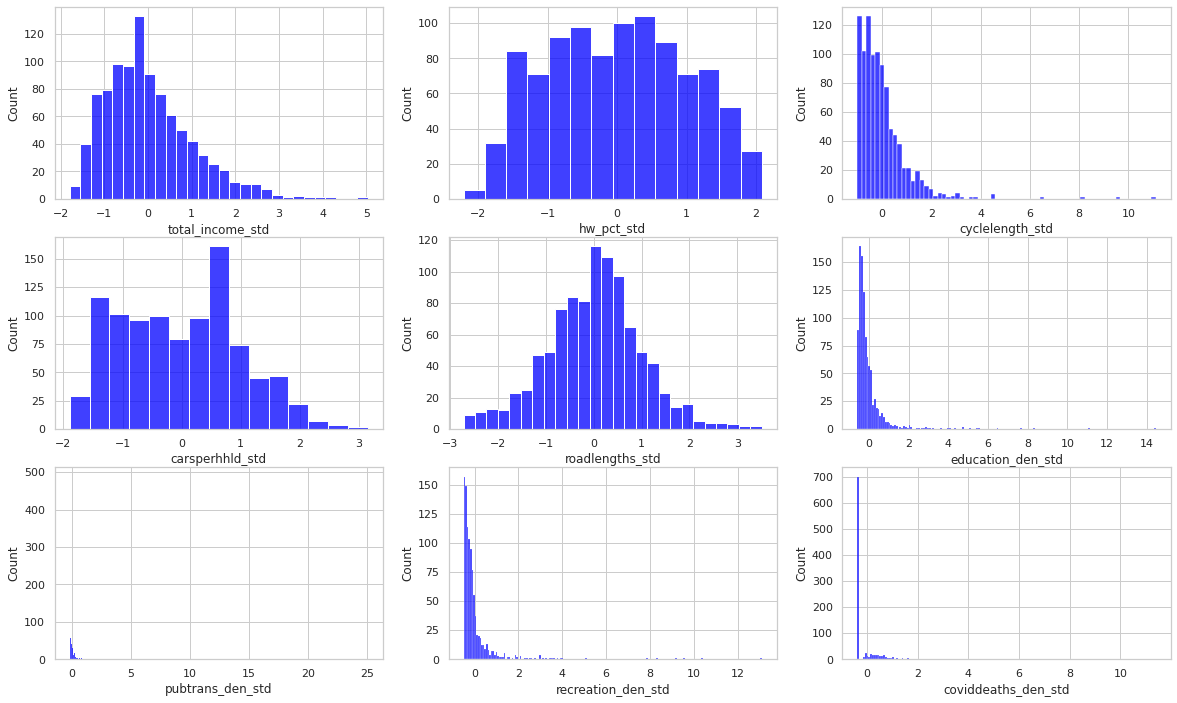

In [11]:
sns.set_context('notebook')

f, ax = plt.subplots(3,3, figsize=(20, 12), sharex = False, sharey = False)

plt_cols = ['total_income_std',
            'hw_pct_std',
              'cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              'education_den_std',
              'pubtrans_den_std',
              'recreation_den_std',
              'coviddeaths_den_std']

k = 0

for i in range(0, 3):
    for j in range(0, 3):
        if k <= (len(plt_cols)-1):
            #print(plt_cols[k])
            sns.histplot(x=plt_cols[k], data = df, ax=ax[i,j], color = 'blue')
            k = k+1
            
#ax[2,0].set_ylim(5)

In [12]:
# Checking to determine number of outliers, may not actually remove.
# Basically, all the outliers identified serve as that strange region that has very high recovery rates.

IQR_s = df['slope'].quantile(0.75) - df['slope'].quantile(0.25)
low_s = df['slope'].quantile(0.25) - 1.5*IQR_s
high_s = df['slope'].quantile(0.75) + 1.5*IQR_s

outlier_low_s = df[df['slope'] < low_s]
outlier_high_s = df[df['slope'] > high_s]

outliers = pd.concat([outlier_low_s, outlier_high_s])
outliers.groupby(['region', 'subregion', 'la_name'])['msoa_name'].agg('count')
#outliers[['msoa_name', 'slope']]

region  subregion                  la_name               
Inner   Inner East                 Hackney                    2
                                   Lewisham                   1
                                   Newham                     3
                                   Tower Hamlets              2
        Inner West                 Camden                     1
                                   Kensington and Chelsea     2
                                   Wandsworth                 3
Outer   Outer East and North East  Barking and Dagenham       1
                                   Bexley                     1
                                   Enfield                    2
                                   Greenwich                  2
                                   Waltham Forest             1
        Outer South                Bromley                    1
                                   Croydon                    6
                                   Kingston up

### Spatial Autocorrelation
Create a spatial weights matrix, visualise the neighbours for the report. Calculate bivariate Moran's I for all variables. 

In [13]:
# Create a weights matrix for row-standardisation based on distance

w = weights.distance.KNN.from_dataframe(df, k = 6)
w.transform = 'R'
w

In [14]:
# Add spatial weight of slope to dataframe for Spatial Regression Models

# Assign spatial lag to df
df['w_slope'] = weights.spatial_lag.lag_spatial(w, df['slope'])
#df['qW_slope'] = weights.spatial_lag.lag_spatial(qW, df['slope'])
#df['knnW_slope'] = weights.spatial_lag.lag_spatial(w_knn, df['slope'])

Text(0.5, 1.0, 'Camden Borough and MSOA Camden 001')

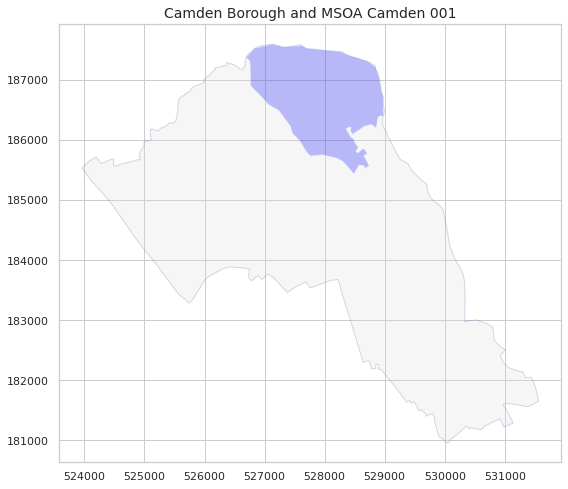

In [15]:
sns.set_context('notebook')

# Plotting City of London's neighbours as an example
# need to label the actual neighbours, follow here to find more: https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
f, ax = plt.subplots(1, figsize=(9, 9))
#plotmsoas = df.plot(ax=ax,alpha=0.8,color='gainsboro', edgecolor = 'w')
plotboroughs = boroughs[boroughs['NAME']=='Camden'].plot(ax=ax,alpha=0.25,color='gainsboro', edgecolor = 'b')
plotmsoa = msoas[msoas['MSOA11NM']=='Camden 001'].plot(ax=ax,alpha=0.25,color='blue')

#ax.axis([530500, 534000, 179250,  182750])
#ax.set_axis_off()
plotmsoa.set_title("Camden Borough and MSOA Camden 001", fontsize = 14)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Text(0.5, 1.0, 'Camden 001: Six Nearest Neighbours')

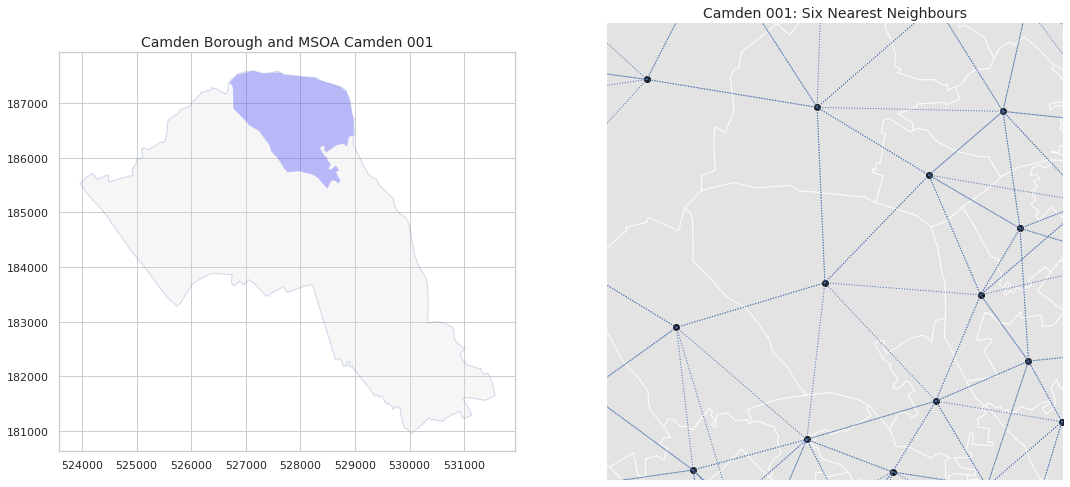

In [16]:
sns.set_context('notebook')

# Plotting City of London's neighbours as an example
# need to label the actual neighbours, follow here to find more: https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
# also here: http://darribas.org/gds15/content/labs/lab_05.html
f, ax = plt.subplots(1,2, figsize=(18, 9))

plotboroughs = boroughs[boroughs['NAME']=='Camden'].plot(ax=ax[0],alpha=0.25,color='gainsboro', edgecolor = 'b')
plotm = msoas[msoas['MSOA11NM']=='Camden 001'].plot(ax=ax[0],alpha=0.25,color='blue')
plotm.set_title("Camden Borough and MSOA Camden 001", fontsize = 14)

plotmsoas = df.plot(ax=ax[1],alpha=0.8,color='gainsboro', edgecolor = 'w')
plotmsoa = msoas[msoas['MSOA11NM']=='Camden'].plot(ax=ax[1],alpha=0.25,color='blue')
plotneighbours = w.plot(df,
                       edge_kws = dict(color='b', linestyle=':', linewidth=1),
                       #node_kws=dict(marker=''),
                       ax = ax[1]
                       )
ax[1].axis([526000, 530000, 185000,  189000])
ax[1].set_axis_off()
plotmsoa.set_title("Camden 001: Six Nearest Neighbours", fontsize = 14)

In [17]:
# Calculate Moran's I and significance. Moran's I can range from -1 to 1, showing a weak positive autocorrelation in this case.

#df = spatial_recovery_jun#[slope_msoa['slope']<.06]

moran = esda.moran.Moran(df['slope'], w)

print(moran.I)
print(moran.p_sim)

0.38811890595438087
0.001


(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.39', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.39)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

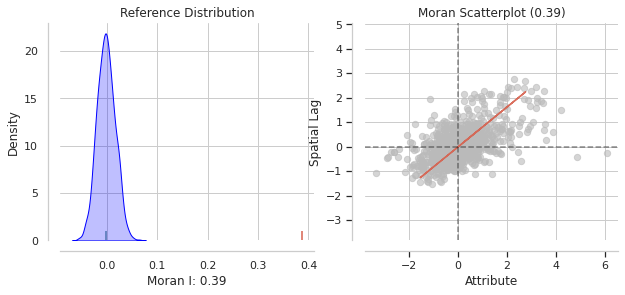

In [18]:
sns.set_context('notebook')
plot_moran(moran, color = 'blue')

In [19]:
# Calculate a bivariate Moran statistic to understand whether including lags of other variables will add value

#df = spatial_recovery

moran_cols = ['total_income_std',
            'hw_pct_std',
              'cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              'education_den_std',
              'pubtrans_den_std',
              'recreation_den_std',
              'coviddeaths_den_std']

for i in range(0,(len(moran_cols))):
    moranbv = esda.Moran_BV(df['slope'], df[moran_cols[i]], w)
    print(moran_cols[i])
    print(moranbv.I)
    print(moranbv.p_sim)


total_income_std
-0.0344214383158309
0.058
hw_pct_std
-0.1006878745893997
0.001
cyclelength_std
-0.08031373119587625
0.001
carsperhhld_std
0.2039627822480002
0.001
roadlengths_std
-0.12120467941785176
0.001
education_den_std
0.02758981769764945
0.114
pubtrans_den_std
-0.026071104820165693
0.1
recreation_den_std
0.02574684455315183
0.122
coviddeaths_den_std
0.07023635436227982
0.005


### Hotspot Analysis
To build an intuition of which regions have an unusual behaviour.

In [20]:
## Code practice from https://geographicdata.science/book/notebooks/

# Create metrics for a Moran Plot

# standardise the slope and spatial lag to plot
df['slope_std'] = (df['slope']-df['slope'].mean())/df['slope'].std()
df['w_slope_std'] = (df['w_slope']-df['w_slope'].mean())/df['w_slope'].std()

In [21]:
df.head()

,msoa_name,msoa_code,la_name,la_code,region,subregion,slope,log_slope,imd_score,total_inco,...,log_recreation_cnt,recreation_den_std,log_recreation_den,coviddeaths_std,coviddeaths_den_std,log_covi_2,geometry,w_slope,slope_std,w_slope_std
0,Hackney 001,E02000345,Hackney,E09000012,Inner,Inner East,4.75,1.56,29.00,40700,...,0.81,-0.26,-0.43,0.89,-0.05,None,"POLYGON ((534525.605 188090.235, 534584.412 18...",3.71,2.20,1.32
1,Hackney 002,E02000346,Hackney,E09000012,Inner,Inner East,2.76,1.01,47.17,34800,...,-0.36,-0.37,-0.87,-0.55,-0.38,None,"POLYGON ((532862.852 187882.922, 532881.637 18...",2.82,-0.25,-0.27
2,Hackney 003,E02000347,Hackney,E09000012,Inner,Inner East,3.37,1.21,29.00,37900,...,-0.36,-0.38,-0.95,-0.55,-0.38,None,"POLYGON ((533332.171 187758.341, 533297.001 18...",3.62,0.50,1.16
3,Hackney 004,E02000348,Hackney,E09000012,Inner,Inner East,4.55,1.51,33.21,34000,...,2.04,0.13,0.28,0.89,-0.05,None,"POLYGON ((534255.696 187936.064, 534137.284 18...",3.88,1.95,1.63
4,Hackney 006,E02000350,Hackney,E09000012,Inner,Inner East,2.84,1.04,24.31,52000,...,0.16,-0.38,-0.92,-0.55,-0.38,None,"POLYGON ((534265.313 187375.219, 534254.242 18...",3.99,-0.15,1.82


Text(-2, -2, 'LL')

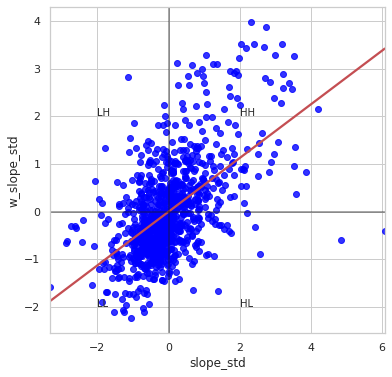

In [22]:
# Code for Moran Plot
# how to add text to plot for variables: https://notebook.community/ljwolf/ucgis_workshop_2016/notebooks/05%20-%20ESDA

f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(x='slope_std', y='w_slope_std', data=df, ci=None, line_kws={'color':'r'}, color = 'blue')

# Create quadrants
# Add vertical, horizontal lines at origin and labels
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
plt.text(2, 2, "HH", fontsize=10)
plt.text(2, -2, "HL", fontsize=10)
plt.text(-2, 2, "LH", fontsize=10)
plt.text(-2, -2, "LL", fontsize=10)


/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

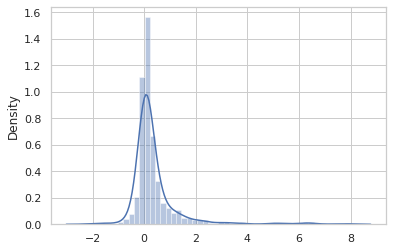

In [23]:
# Calculate Moran's I for each datapoint
lisa = esda.moran.Moran_Local(df['slope'],w)

# add to df, set back to main dataframe
df['Is'] = lisa.Is

# plot the distribution, which looks somewhat normal
sns.distplot(lisa.Is)

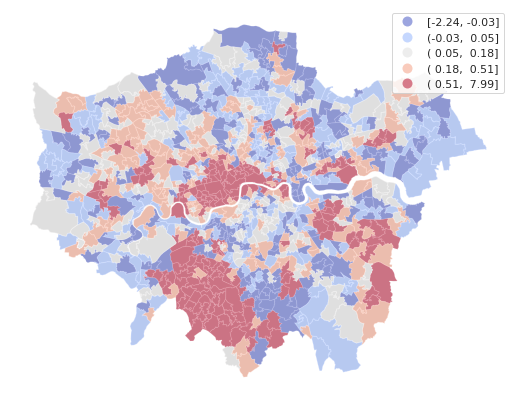

In [24]:
# Spatial plot of lisa
f, ax = plt.subplots(1, figsize=(9,9))

plotmsoa = msoas.plot(ax=ax,alpha=0.8,color='gainsboro')
df.plot(column='Is', cmap='coolwarm', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.5, legend=True,ax=ax);
ax.set_axis_off()

In [25]:
# Count the number of datapoints within each quadrant, perhaps if evenly distributed then this is purely random
# 1 = HH, 2 = LH, 3 = LL, 4 = HL
# results show that 23 are in HH/LL, balance in LH/HL.
counts = [(j,(lisa.q == j).sum()) for j in range(1,5)]
print(counts)

[(1, 273), (2, 137), (3, 438), (4, 133)]


In [26]:
# Furthermore, we'll assign each value to a cluster based on its significance of autocorrelation
sig = 1*(lisa.p_sim < 0.05) # binary to indicate which msoas are significant
df['p-sim'] = lisa.p_sim
df['sig'] = sig
#df[['msoa_name','sig', 'p-sim']].head()

In [27]:
# Now we label the data with not-significant, hh, ll, hl, lh. 

hh = 1*(sig*lisa.q==1)
ll = 3*(sig*lisa.q==3)
lh = 2*(sig*lisa.q==2)
hl = 4*(sig*lisa.q==4)
spots = hh + ll + lh + hl
spot_labels = ['0 ns', '1 hh', '2 lh', '3 ll', '4 hl']
labels = [spot_labels[i] for i in spots]
df['labels'] = labels

df = df
[(spot_label, (df['labels']==spot_label).sum()) for spot_label in spot_labels]

[('0 ns', 687), ('1 hh', 112), ('2 lh', 34), ('3 ll', 129), ('4 hl', 19)]

In [28]:
df.groupby(['labels', 'subregion'])['msoa_name'].agg('count')

labels  subregion                
0 ns    Inner East                   221
        Inner West                    55
        Outer East and North East    161
        Outer South                   70
        Outer West and North West    180
1 hh    Inner East                    12
        Inner West                    12
        Outer East and North East     23
        Outer South                   65
2 lh    Inner East                     8
        Inner West                     2
        Outer East and North East      9
        Outer South                   15
3 ll    Inner East                    13
        Inner West                    60
        Outer East and North East     14
        Outer South                    1
        Outer West and North West     41
4 hl    Inner East                     5
        Inner West                     7
        Outer East and North East      1
        Outer South                    1
        Outer West and North West      5
Name: msoa_name, dtype:

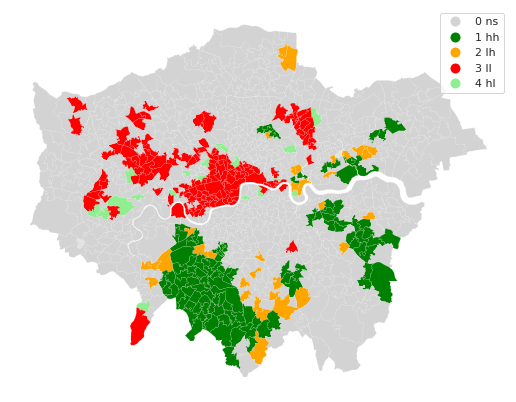

In [29]:
# Plot labels based on significance
# Based on this, we can visually see that it is central and west london that appear to be in the ll quadrant significantly, only Redbridge in the hh quadrant is significant.
# Based on the Moran plot, those that are negative are statistically significantly below the mean standardised slope of all local authorities.

f, ax = plt.subplots(1, figsize=(9,9))
hmap = colors.ListedColormap(['lightgrey', 'green', 'orange', 'red', 'lightgreen'])

plotmsoa = boroughs.plot(ax=ax,alpha=0.8,color='gainsboro')
df.plot(column='labels', categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax,
        edgecolor='white', legend=True)
ax.set_axis_off()

Text(0.5, 1.0, 'LISA Spatial Plot')

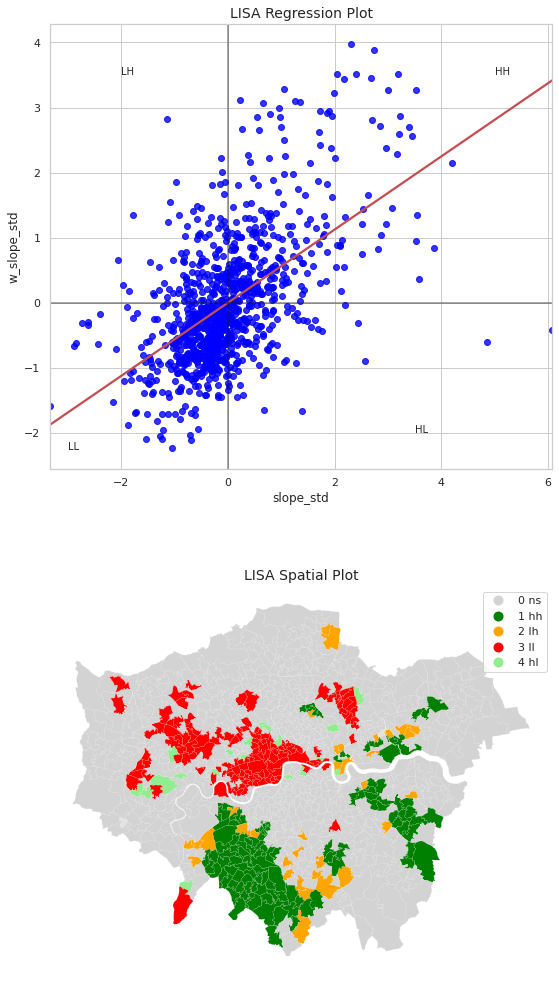

In [30]:
#sns.set_context('notebook')

f, ax = plt.subplots(2, 1, figsize=(9,18))

# Plot values
p = sns.regplot(x='slope_std', y='w_slope_std', data=df, ci=None, line_kws={'color':'r'}, color = 'blue', ax = ax[0])

# Create quadrants
# Add vertical, horizontal lines at origin and labels
ax[0].axvline(0, c='k', alpha=0.5)
ax[0].axhline(0, c='k', alpha=0.5)
ax[0].text(5, 3.5, "HH", fontsize=10)
ax[0].text(3.5, -2, "HL", fontsize=10)
ax[0].text(-2, 3.5, "LH", fontsize=10)
ax[0].text(-3, -2.25, "LL", fontsize=10)
#p.xlabel("Standardised Recovery Rate")
#p.ylabel("Standardised Spatial Lag of Recovery Rate")
ax[0].set_title("LISA Regression Plot", fontsize = 14)



hmap = colors.ListedColormap(['lightgrey', 'green', 'orange', 'red', 'lightgreen'])

plotmsoa = boroughs.plot(ax=ax[1],alpha=0.8,color='gainsboro')
df.plot(column='labels', categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax[1],
        edgecolor='white', legend=True)
ax[1].set_axis_off()

ax[1].set_title("LISA Spatial Plot", fontsize = 14)

### Spatial Regression Model
Regression Models created: OLS, Spatial Lag, Spatial Error, and GWR.

In [31]:
# Spatial Regression Models: OLS, Spatial Lag, Spatial Error
# http://andrewgaidus.com/Spatial_Econonometric_Modeling/

y = df['slope']

cols = ['total_income_std',
        'hw_pct_std',
        'cyclelength_std',
        'carsperhhld_std',
        'roadlengths_std',
        'education_den_std',
        'pubtrans_den_std',
        'recreation_den_std',
        'coviddeaths_den_std']

x = df.loc[:, cols]
#x.values

In [32]:
model_ols = spreg.OLS(y.values[:, None], x.values, w=w, spat_diag = True, moran = True, name_x = cols, name_y = 'slope')
moran_ols = esda.moran.Moran(model_ols.u, w)

print(model_ols.summary)
print(moran_ols.I)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         981
Mean dependent var  :      2.9576                Number of Variables   :          10
S.D. dependent var  :      0.8151                Degrees of Freedom    :         971
R-squared           :      0.0866
Adjusted R-squared  :      0.0781
Sum squared residual:     594.728                F-statistic           :     10.2277
Sigma-square        :       0.612                Prob(F-statistic)     :   3.639e-15
S.E. of regression  :       0.783                Log likelihood        :   -1146.499
Sigma-square ML     :       0.606                Akaike info criterion :    2312.997
S.E of regression ML:      0.7786                Schwarz criterion     :    2361.883

-----------------------------------------------------------------------------

In [33]:
# OLS with Spatial Weights in x
cols = ['total_income_std',
        'hw_pct_std',
        'cyclelength_std',
        'carsperhhld_std',
        'roadlengths_std',
        'education_den_std',
        'pubtrans_den_std',
        'recreation_den_std',
        'coviddeaths_den_std',
        'w_slope']
x = df.loc[:, cols]

model2 = spreg.OLS(y.values[:, None], x.values, w=w, spat_diag = True, moran = True, name_x = cols, name_y = 'slope')
print(model2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         981
Mean dependent var  :      2.9576                Number of Variables   :          11
S.D. dependent var  :      0.8151                Degrees of Freedom    :         970
R-squared           :      0.3355
Adjusted R-squared  :      0.3286
Sum squared residual:     432.675                F-statistic           :     48.9694
Sigma-square        :       0.446                Prob(F-statistic)     :   2.505e-79
S.E. of regression  :       0.668                Log likelihood        :    -990.463
Sigma-square ML     :       0.441                Akaike info criterion :    2002.926
S.E of regression ML:      0.6641                Schwarz criterion     :    2056.700

-----------------------------------------------------------------------------

In [34]:
# Spatial Lag model
cols = ['total_income_std',
        'hw_pct_std',
        'cyclelength_std',
        'carsperhhld_std',
        'roadlengths_std',
        'education_den_std',
        'pubtrans_den_std',
        'recreation_den_std',
        'coviddeaths_den_std']

x = df.loc[:, cols]

model_lag = spreg.GM_Lag(y.values[:, None], x.values, w=w, spat_diag = True, name_x = cols, name_y = 'slope')
moran_lag = esda.moran.Moran(model_lag.u, w)
print(model_lag.summary)
print(f"Moran's I of Residuals:{moran_lag.I}, significance: {moran_lag.p_sim}")
print(f"AIC {spreg.diagnostics.akaike(model_lag)}")

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         981
Mean dependent var  :      2.9576                Number of Variables   :          11
S.D. dependent var  :      0.8151                Degrees of Freedom    :         970
Pseudo R-squared    :      0.3338
Spatial Pseudo R-squared:  0.0699

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.9868907       0.5430391       1.8173475       0.0691639
    total_income_std      -0.1259952       0.0445334      -2.8292326       0.0046660
          hw_pct_std       0.0289488       0.0442626       

In [35]:
# Spatial Error Model, treats spatial autocorrelation as a 'nuisance' in the lambda variable.

model_error = spreg.GM_Error_Het(y.values[:, None], x.values, w=w, name_x = cols, name_y = 'slope')
moran_error = esda.moran.Moran(model_error.u, w)
print(model_error.summary)
print(f"Moran's I of Residuals:{moran_error.I}, significance: {moran_error.p_sim}")
#print(f"AIC {spreg.diagnostics.akaike(model_error)}")

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         981
Mean dependent var  :      2.9576                Number of Variables   :          10
S.D. dependent var  :      0.8151                Degrees of Freedom    :         971
Pseudo R-squared    :      0.0809
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       2.9446793       0.0548249      53.7106620       0.0000000
    total_income_std      -0.1670179       0.0575228      -2.9035069       0.00

In [36]:
# Create parameters for GWR
g_coords = list(zip(df.centroid.x, df.centroid.y))

g_y = y.values.reshape((-1,1))
g_x = x.values

In [37]:
# Select bandwidth for the GWR model

selector = Sel_BW(g_coords, g_y, g_x, spherical = False)
bw = selector.search()
print(bw)

341.0


In [38]:
# https://github.com/pysal/gwr/blob/master/gwr/notebooks/GWR_Georgia_Example.ipynb

#Find optimal bandwidth using golden section search to minimize AICc

#Instantiate bandwidth selection class - bisquare NN (adaptive)
bw = Sel_BW(g_coords, g_y, g_x, kernel='bisquare', fixed=False)

#Find optimal bandwidth by minimizing AICc using golden section search algorithm
bw = bw.search('golden_section', criterion='AICc')
print(bw)



341.0


In [39]:
# GWR

model_gwr = GWR(g_coords, g_y, g_x, bw).fit()
model_gwr.summary()

Model type                                                         Gaussian
Number of observations:                                                 981
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            594.728
Log-likelihood:                                                   -1146.499
AIC:                                                               2312.997
AICc:                                                              2315.270
BIC:                                                              -6094.076
R2:                                                                   0.087
Adj. R2:                                                              0.078

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [40]:
df['R2'] = model_gwr.localR2

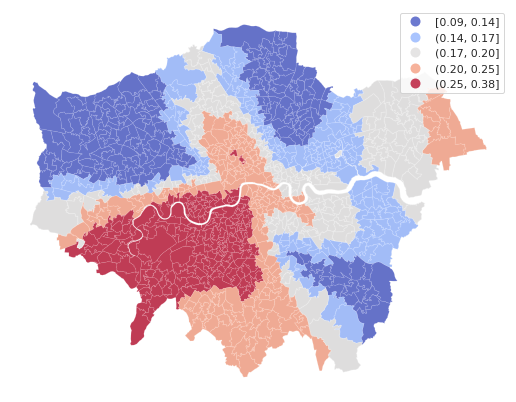

In [41]:
# Plot local R2

f, ax = plt.subplots(1, figsize=(9,9))

plotmsoa = msoas.plot(ax=ax,alpha=0.8,color='gainsboro')
df.plot(column='R2', cmap= 'coolwarm', scheme = 'quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
ax.set_axis_off()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/opt/conda/envs/sds2020/lib/python3.7/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


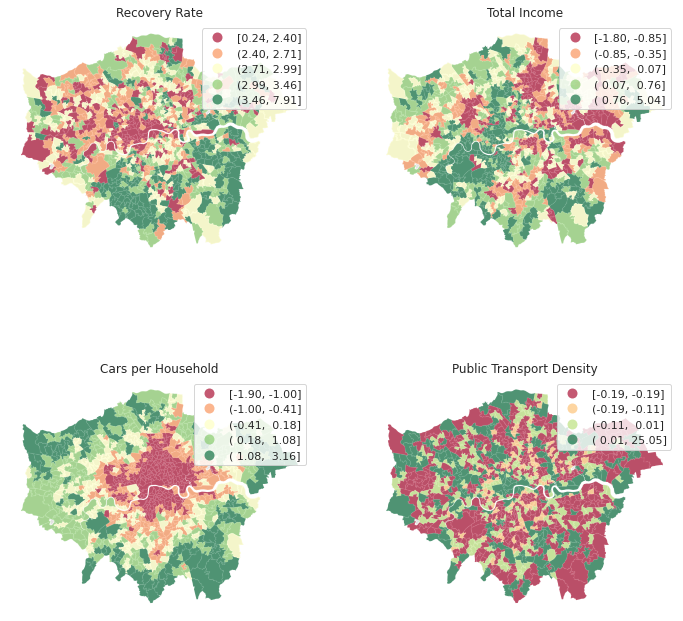

In [42]:
sns.set_context('notebook')

# Plotting variables selected to see spatial patterns. Based on the above: total_income, cars_perhhld, pubtrans_dens
# are statistically significant across all models.

f, ax = plt.subplots(2,2, figsize=(12, 12))

#df = spatial_recovery
#df = df[(df['cyclelength_perhect_std']<200)&(df['pubtrans_cnt_std']<30)&(df['busstops_cnt_std']<75)]


plotmsoa = msoas.plot(ax=ax[0,0],alpha=0.8,color='gainsboro')
plotslope = df.plot(column='slope', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       legend=True,
                       #legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax[0,0]
                      )
ax[0,0].set_title('Recovery Rate')
ax[0,0].set_axis_off()


plotmsoa = msoas.plot(ax=ax[0,1],alpha=0.8,color='gainsboro')
plotinc = df.plot(column='total_income_std', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       legend=True,
                       #legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax[0,1]
                      )
ax[0,1].set_title('Total Income')
ax[0,1].set_axis_off()

plotmsoa = msoas.plot(ax=ax[1,0],alpha=0.8,color='gainsboro')
plotscars = df.plot(column='carsperhhld_std', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       legend=True,
                       #legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax[1,0]
                      )
ax[1,0].set_title('Cars per Household')
ax[1,0].set_axis_off()


plotmsoa = msoas.plot(ax=ax[1,1],alpha=0.8,color='gainsboro')
plotpubtrans = df.plot(column='pubtrans_den_std', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       legend=True,
                       #legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax[1,1]
                      )
ax[1,1].set_title('Public Transport Density')
ax[1,1].set_axis_off()



In [44]:
#model_gwr.filter_tvals()
#model_gwr.params[:,2]
#model_gwr.params.shape
#model_gwr.params.shape[1]
#x.columns

In [45]:
gwrlabels = ['intercept', 'total_income_std', 'hw_pct_std', 'cyclelength_std', 'carsperhhld_std',
       'roadlengths_std', 'education_den_std', 'pubtrans_den_std',
       'recreation_den_std', 'coviddeaths_den_std']

len(gwrlabels)

10

Text(0.5, 1.0, 'pubtrans_den_std Estimates')

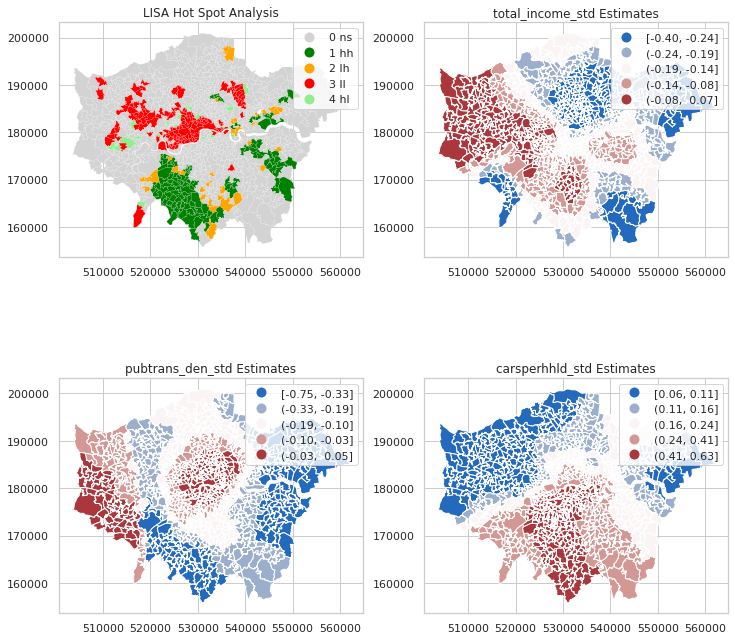

In [63]:
#Map Parameter estimates and T-vals for each covariate
# code from https://github.com/pysal/gwr/blob/master/gwr/notebooks/GWR_Georgia_Example.ipynb

f, ax = plt.subplots(2,2, figsize=(12, 12))


df.plot(column='labels', categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax[0,0],
        edgecolor='white', legend=True)
ax[0,0].set_title('LISA Hot Spot Analysis')

plt_rng = [1,4,7]

param = plt_rng[0]
df[str(param)] = model_gwr.params[:,param]
df.plot(str(param), figsize=(8,8), cmap='vlag', scheme = 'quantiles', legend = True, ax = ax[0,1])
ax[0,1].set_title(gwrlabels[param] + ' Estimates')

param = plt_rng[1]
df[str(param)] = model_gwr.params[:,param]
df.plot(str(param), figsize=(8,8), cmap='vlag', scheme = 'quantiles', legend = True, ax = ax[1,1])
ax[1,1].set_title(gwrlabels[param] + ' Estimates')

param = plt_rng[2]
df[str(param)] = model_gwr.params[:,param]
df.plot(str(param), figsize=(8,8), cmap='vlag', scheme = 'quantiles', legend = True, ax = ax[1,0])
ax[1,0].set_title(gwrlabels[param] + ' Estimates')



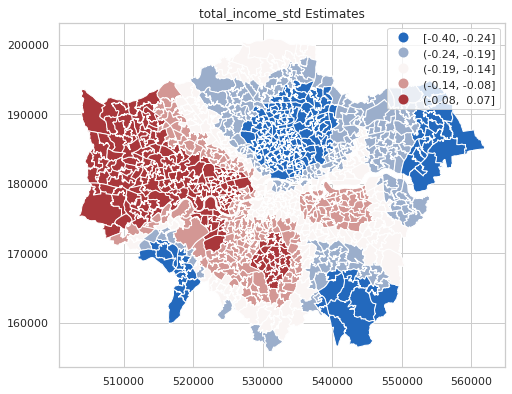

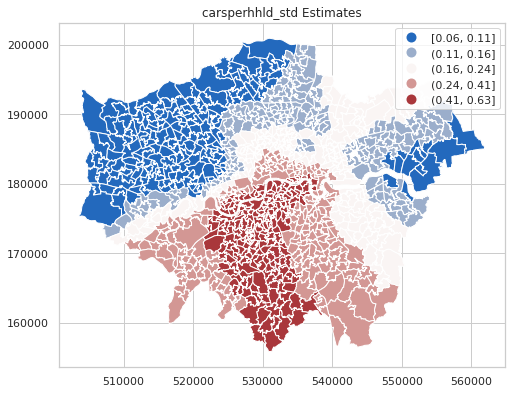

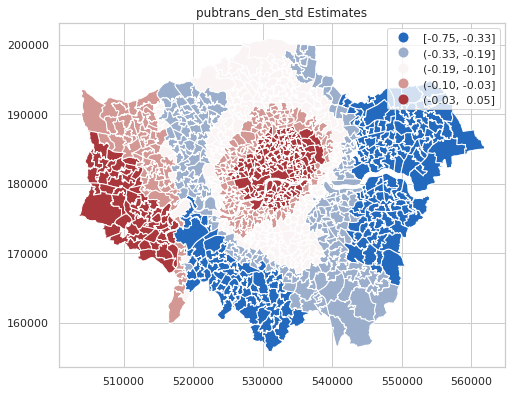

In [53]:
#Map Parameter estimates and T-vals for each covariate
# code from https://github.com/pysal/gwr/blob/master/gwr/notebooks/GWR_Georgia_Example.ipynb
#f, ax = plt.subplots(2,2, figsize=(12, 12))

plt_rng = [1,4,7]


for param in plt_rng:#range(model_gwr.params.shape[1]):
    df[str(param)] = model_gwr.params[:,param]
    #vmin, vmax = np.min(df[str(param)]), np.max(df[str(param)]) 
    #ax = df.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='RdYlGn', scheme = 'quantiles', legend = True)
    ax = df.plot(str(param), figsize=(8,8), cmap='vlag', scheme = 'quantiles', legend = True)
    ax.set_title(gwrlabels[param] + ' Estimates')
    #fig = ax.get_figure()
    #cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    #sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd')
    #sm._A = []
    #fig.colorbar(sm, cax=cax)
    
    #df[str(param)] = model_gwr.tvalues[:,param]
    #vmin, vmax = np.min(df[str(param)]), np.max(df[str(param)]) 
    #ax = df.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Greys')
    #ax.set_title(gwrlabels[param] + ' T-vals')
    #fig = ax.get_figure()
    #cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    #sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Greys')
    #sm._A = []
    #fig.colorbar(sm, cax=cax)



In [64]:
# Spatial Lag model with log variables
cols = ['total_income_std',
        'hw_pct_std',
        'cyclelength_std',
        'carsperhhld_std',
        'roadlengths_std',
        'log_education_den',
        'log_pubtrans_den',
        'log_recreation_den',
        'coviddeaths_den_std']

x = df.loc[:, cols]

model_laglog = spreg.GM_Lag(y.values[:, None], x.values, w=w, spat_diag = True, name_x = cols, name_y = 'slope')
moran_laglog = esda.moran.Moran(model_lag.u, w)
print(model_laglog.summary)
print(f"Moran's I of Residuals:{moran_laglog.I}, significance: {moran_laglog.p_sim}")
print(f"AIC {spreg.diagnostics.akaike(model_laglog)}")

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       slope                Number of Observations:         981
Mean dependent var  :      2.9576                Number of Variables   :          11
S.D. dependent var  :      0.8151                Degrees of Freedom    :         970
Pseudo R-squared    :      0.2938
Spatial Pseudo R-squared:  0.0828

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       1.9198403       0.8073215       2.3780370       0.0174051
    total_income_std      -0.1563429       0.0465600      -3.3578823       0.0007854
          hw_pct_std       0.0389133       0.0472761       

In [65]:
# GWR with Log Variables
g_coords = list(zip(df.centroid.x, df.centroid.y))

g_y = y.values.reshape((-1,1))
g_x = x.values

# Select bandwidth for the GWR model

selector = Sel_BW(g_coords, g_y, g_x, spherical = False)
bw = selector.search()
print(bw)

# GWR

model_gwrlog = GWR(g_coords, g_y, g_x, bw).fit()
model_gwrlog.summary()

375.0
Model type                                                         Gaussian
Number of observations:                                                 981
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            594.627
Log-likelihood:                                                   -1146.416
AIC:                                                               2312.832
AICc:                                                              2315.104
BIC:                                                              -6094.177
R2:                                                                   0.087
Adj. R2:                                                              0.078

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- 

Text(0.5, 1.0, 'pubtrans_den_std Estimates')

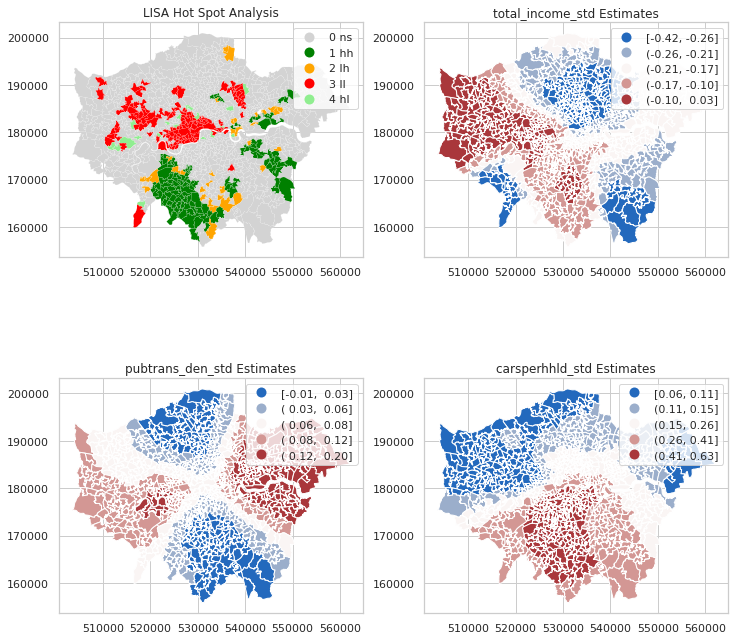

In [66]:
#Map Parameter estimates and T-vals for each covariate
# code from https://github.com/pysal/gwr/blob/master/gwr/notebooks/GWR_Georgia_Example.ipynb

f, ax = plt.subplots(2,2, figsize=(12, 12))


df.plot(column='labels', categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax[0,0],
        edgecolor='white', legend=True)
ax[0,0].set_title('LISA Hot Spot Analysis')

plt_rng = [1,4,7]

param = plt_rng[0]
df[str(param)] = model_gwrlog.params[:,param]
df.plot(str(param), figsize=(8,8), cmap='vlag', scheme = 'quantiles', legend = True, ax = ax[0,1])
ax[0,1].set_title(gwrlabels[param] + ' Estimates')

param = plt_rng[1]
df[str(param)] = model_gwrlog.params[:,param]
df.plot(str(param), figsize=(8,8), cmap='vlag', scheme = 'quantiles', legend = True, ax = ax[1,1])
ax[1,1].set_title(gwrlabels[param] + ' Estimates')

param = plt_rng[2]
df[str(param)] = model_gwrlog.params[:,param]
df.plot(str(param), figsize=(8,8), cmap='vlag', scheme = 'quantiles', legend = True, ax = ax[1,0])
ax[1,0].set_title(gwrlabels[param] + ' Estimates')



In [47]:
# Unused Code

# Trying out colour schemes

#tfl_cmap = sns.diverging_palette(250, 10, n=9, as_cmap = True)

#tfl_cmap = sns.diverging_palette(sns.color_palette('#3333CC', 1), sns.color_palette('#FF3333', 1), n=9, as_cmap = True)

# Fill na for fields that do not have values to allow for OLS model to run

#df = spatial_recovery_jun

#cols = ['imd_score_std',
#        'total_income_std', 
#        'carsperhhld_std',
#        'hw_pct_std',
#        'education_cnt_std',
#        'busstops_cnt_std',
#        'pubtrans_cnt_std',
#        'recreation_cnt_std',
#        'roadlengths_std',
#        'cyclelength_std',
#        'trips_std',
#        'coviddeaths_std']

#for i in range(0,len(cols)):
#    df[cols[i]] = df[cols[i]].fillna(0)

#spatial_recovery = df

# Pairwise plot to see if there is a linear relationship. Excluding potential outliers (slope > 0.06)

#f, ax = plt.subplots(1, figsize=(20, 20))

#df = slope_msoa[slope_msoa['slope']<.06]
#df['log_length'] = np.log(df['length'])

#cols_to_plot = ['slope',
#                'hw_pct_std',
#                'income_std',
#                'pubtranspp']

#sns.pairplot(df, vars=cols_to_plot, markers=".", height=3)

# See attributes of the spatial weights matrix
#print(w.neighbors)
#print(w.islands)
#print(w.histogram)
#print(w.weights)

# Create a weights matrix based on nearest neighbours
# http://darribas.org/gds15/content/labs/lab_05.html

#w_knn = weights.KNN.from_shapefile('output_data/spatial_recovery.shp', k = 6)
#w_knn.transform = 'R'
#w_knn
#w_knn.plot(df)

# Create a weights matrix based on contiguity
# https://splot.readthedocs.io/en/stable/users/tutorials/weights.html#pysal-spatial-weight-types

#qW = weights.Queen.from_shapefile('output_data/slope_msoa.shp')
#qW.transform = 'R'
#qW
#qW.plot(df)